In [1]:
# this is a little trick to make sure the the notebook takes up most of the screen:
from IPython.display import HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Recommendation to leave the logging config like this, otherwise you'll be flooded with unnecessary info
import logging
logging.basicConfig(level=logging.WARNING, format='%(levelname)s:%(message)s')  


# Recommendation: logging config like this, otherwise you'll be flooded with unnecessary information
import logging
logging.basicConfig(level=logging.ERROR)

import sys
sys.path.append('../')

In [2]:
# import all modeling concepts
from crestdsl.model import *

# import the simulator
from crestdsl.simulation import Simulator

# import the plotting libraries that can visualise the CREST systems
from crestdsl.ui import elk

# we will create tests for each Entity
import unittest

class TestClass(unittest.TestCase):
    @classmethod
    def runall(cls):
        tests = unittest.TestLoader().loadTestsFromTestCase(cls)
        return unittest.TextTestRunner().run(tests)
    


In [3]:
# import all the resources you will use in the SmartHome model
class Resources(object):
    electricity = Resource("Watt", REAL)
    switch = Resource("switch", ["on", "off"])
    pourcent = Resource("%", REAL) 
    light = Resource("Lumen", INTEGER)
    time = Resource("minutes", REAL)
    water = Resource("litre", REAL)
    celsius = Resource("Celsius", REAL)
    boolean = Resource("bool", BOOL)
    presence = Resource("presence", ["detected", "no presence"])
    onOffAuto = Resource("onOffAutoSwitch", ["on", "off", "auto"])
    integer = Resource("integer", INTEGER)
    weight = Resource("kg", REAL)
    lenght = Resource("m", REAL)
    area = Resource("m²", REAL)

In [4]:
# Those are the 2 types of object we will use here
class ElectricalDevice(object):
    electricity_in = Input(Resources.electricity, value=0)
    req_electricity_out = Output(Resources.electricity, value=0)
    
class WaterDevice(object):
    water_in = Input(Resources.water, value=0)
    req_water_out = Output(Resources.water, value=0)

In [ ]:
# The Boiler model we made is highly inspired by 
# https://www.ethz.ch/content/dam/ethz/special-interest/itet/institute-eeh/power-systems-dam/documents/SAMA/2017/Rodriguez-SA-2017.pdf
# But we assume that there is no (in our model) looses due to the environnement and that our heat generator is on all of our disks 
# (vertically in all the tank) and heats them all at the same time

In [5]:
# Even if we will not use it, I made the entity of a regular disk, like the non heated ones is the paper 
class RegularDisk(Entity):
    
    """ - - - - - - - PORTS - - - - - - - - - - """
    
    temp_up = Input(Resources.celsius, 45)
    temp_down = Input(Resources.celsius, 45)
    water_drawn = Input(Resources.water, 8)
    
    actual_Temp = Output(Resources.celsius, 40)
    
    act_Temp = Local(Resources.celsius, 40)
    mass_disk = Local(Resources.weight, 12)
    element_thickness = Local(Resources.lenght, 0.2)
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """

    state = current = State()
    
    """ - - - - - - - UPDATES - - - - - - - - - - """
    
    influence_act_temp = Influence(source=act_Temp, target=actual_Temp)
    
    @update(state=state, target=act_Temp)
    def set_act_Temp_on(self, dt):

        dTiDiff = (0.6/(1000*4185.5*self.element_thickness.value*self.element_thickness.value))*(self.temp_down.pre+self.temp_up.pre-
                                                                                                 2*self.actual_Temp.pre)
        dTiDraw = (self.water_drawn.value/self.mass_disk.value)*(self.temp_down.value-self.actual_Temp.pre)
        
        return self.actual_Temp.value + dTiDiff + dTiDraw
    
        
#elk.plot(RegularDisk)

In [6]:
# The disks that will compose the Boiler, updates are form the paper, influences permit to avoid circular dependencies
@nodependencies
class MixingDisk(Entity):

    """ - - - - - - - PORTS - - - - - - - - - - """
    
    temp_up = Input(Resources.celsius, 45)
    temp_down = Input(Resources.celsius, 45)
    water_drawn = Input(Resources.water, 8)
    
    switch_boiler = Input(Resources.switch, "on")
    
    actual_Temp = Output(Resources.celsius, 40)
    
    power_boiler = Local(Resources.electricity, 4000)
    nb_layers = Local(Resources.integer, 1)
    boiler_efficiency = Local(Resources.pourcent, 1)

    max_temp = Local(Resources.celsius, 55)
    min_temp = Local(Resources.celsius, 50)
    
    act_Temp = Local(Resources.celsius, 45)
    mass_disk = Local(Resources.weight, 12)
    element_thickness = Local(Resources.lenght, 0.2)
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """

    off = State()
    heating = current = State()
    
    to_off = Transition(source=heating, target=off, guard=(lambda self: self.switch_boiler.value == "off" or 
                                                               self.act_Temp.value >= self.max_temp.value))
    to_heating = Transition(source=off, target=heating, guard=(lambda self : self.switch_boiler.value == "on" and
                                                                self.act_Temp.value <= self.min_temp.value))
    
                          
    """ - - - - - - - UPDATES - - - - - - - - - - """
    
    influence_act_temp = Influence(source=act_Temp, target=actual_Temp)
    
    @update(state=off, target=act_Temp)
    def set_act_Temp_off(self, dt):

        dTiDiff = (0.6/(1000*4185.5*self.element_thickness.value*self.element_thickness.value))*(self.temp_down.value+self.temp_up.value-
                                                                                                 2*self.act_Temp.pre)
        dTiDraw = ((self.water_drawn.value/60)/self.mass_disk.value)*(self.temp_down.value-self.act_Temp.pre)
        
        return self.act_Temp.value + (dTiDiff + dTiDraw/60)*dt
    
    @update(state=heating, target=act_Temp)
    def set_act_Temp_Heat(self, dt):

        dTiDiff = (0.6 / (1000 * 4185.5 * self.element_thickness.value * self.element_thickness.value))*(self.temp_down.pre + 
                                                                                                           self.temp_up.pre - 
                                                                                                           2*self.act_Temp.pre)
        dTiDraw = ((self.water_drawn.value/60) / self.mass_disk.value) * (self.temp_down.pre - self.act_Temp.pre)
        dTiHeat = self.boiler_efficiency.value * self.power_boiler.value / (self.mass_disk.value * 4185.5 * self.nb_layers.value)
        
        return self.act_Temp.value + (dTiDiff + dTiDraw + dTiHeat)*dt

#elk.plot(MixingDisk)

md = MixingDisk()
sim = Simulator(md)
sim.stabilize()
sim.advance(2700)
sim.plot()

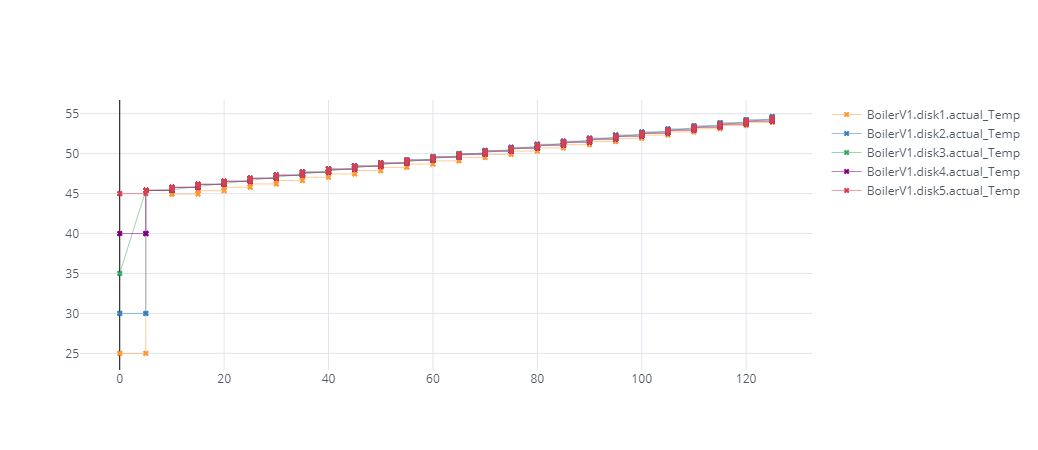

In [13]:
# First try of entire Boiler form the exemple with only 5 disks.

@nodependencies
class BoilerV1(Entity, ElectricalDevice, WaterDevice):

    """ - - - - - - - PORTS - - - - - - - - - - """

    switch_boiler = Input(Resources.switch, "on")
    water_need = Input(Resources.water, 8)
    
    #hot_Water = Output(Resources.water,0) #Going to Shower and/or DW
    
    max_Capacity = Local(Resources.water,60)
    cons_Boiler = Local(Resources.electricity,4000)
    boiler_efficiency = Local(Resources.pourcent, 1)
    
    #max_Temp = Local(Resources.celsius,55)
    #actual_Capacity = Local(Resources.water,50)   Will see later
    #actual_Temp = Local(Resources.celsius,50)
    
    
    
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """

    disk1 = MixingDisk()
    disk2 = MixingDisk()
    disk3 = MixingDisk()
    disk4 = MixingDisk()
    disk5 = MixingDisk()
    

    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """

    state = current = State()
    
    """ - - - - - - - INFLUENCES - - - - - - - - - - """
    influence_switch1 = Influence(source=switch_boiler, target=disk1.switch_boiler)
    influence_switch2 = Influence(source=switch_boiler, target=disk2.switch_boiler)
    influence_switch3 = Influence(source=switch_boiler, target=disk3.switch_boiler)
    influence_switch4 = Influence(source=switch_boiler, target=disk4.switch_boiler)
    influence_switch5 = Influence(source=switch_boiler, target=disk5.switch_boiler)
    
    influence_water_1 = Influence(source=water_need, target=disk1.water_drawn)
    influence_water_2 = Influence(source=water_need, target=disk2.water_drawn)
    influence_water_3 = Influence(source=water_need, target=disk3.water_drawn)
    influence_water_4 = Influence(source=water_need, target=disk4.water_drawn)
    influence_water_5 = Influence(source=water_need, target=disk5.water_drawn)
    
    
    
    #dep1 = Dependency(source="req_water_out", target=water_need)

    
    """ - - - - - - - UPDATES - - - - - - - - - - """
    
    influence_temp_up_1 = Influence(source = disk1.actual_Temp, target = disk1.temp_up)
    influence_temp_up_2 = Influence(source = disk1.actual_Temp, target = disk2.temp_up)
    influence_temp_up_3 = Influence(source = disk2.actual_Temp, target = disk3.temp_up)
    influence_temp_up_4 = Influence(source = disk3.actual_Temp, target = disk4.temp_up)
    influence_temp_up_5 = Influence(source = disk4.actual_Temp, target = disk5.temp_up)
    influence_temp_down_1 = Influence(source = disk2.actual_Temp, target = disk1.temp_down)
    influence_temp_down_2 = Influence(source = disk3.actual_Temp, target = disk2.temp_down)
    influence_temp_down_3 = Influence(source = disk4.actual_Temp, target = disk3.temp_down)
    influence_temp_down_4 = Influence(source = disk5.actual_Temp, target = disk4.temp_down)
    influence_temp_down_5 = Influence(source = disk5.actual_Temp, target = disk5.temp_down)

#elk.plot(Boiler())

bt=BoilerV1()
bt.electricity_in.value=4000

bt.disk1.actual_Temp.value = 25
bt.disk2.actual_Temp.value = 30
bt.disk3.actual_Temp.value = 35
bt.disk4.actual_Temp.value = 40
bt.disk5.actual_Temp.value = 45

"""sim1=Simulator(bt)
sim1.stabilize()
sim1.advance(200)
sim1.plot()  """  

sim1=Simulator(bt)
sim1.stabilize
for i in range(25):
    sim1.advance(5)
sim1.plot(level=2)    
sim1.traces.plot(traces=[bt.disk1.actual_Temp, bt.disk2.actual_Temp, bt.disk3.actual_Temp, bt.disk4.actual_Temp, bt.disk5.actual_Temp])

In [8]:
# Not really important, just a try of a Boiler without discretisation.

@dependency(source="req_electricity_out", target="switch_boiler")
class SimpleBoiler(Entity, ElectricalDevice, WaterDevice):
    
    """ - - - - - - - PORTS - - - - - - - - - - """

    water_drawn = Input(Resources.water, 0)
    
    switch_boiler = Input(Resources.switch, "on")
    
    actual_Temp = Output(Resources.celsius, 40)
    
    cons_boiler = Local(Resources.electricity, 4000)

    max_temp = Local(Resources.celsius, 55)
    min_temp = Local(Resources.celsius, 50)
    act_Temp = Local(Resources.celsius, 40)
    
    mass_disk = Local(Resources.weight, 60)
    
    element_thickness = Local(Resources.lenght, 1)
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """
    
    off = State()
    heating = current = State()
    
    to_off = Transition(source=heating, target=off, guard=(lambda self: self.switch_boiler.value == "off" or 
                                                               self.actual_Temp.value >= self.max_temp.value))
    
    to_heating = Transition(source=off, target=heating, guard=(lambda self : self.switch_boiler.value == "on" and
                                                                self.actual_Temp.value <= self.min_temp.value)) 
                          
    """ - - - - - - - UPDATES - - - - - - - - - - """
    
    influence_act_temp = Influence(source=act_Temp, target=actual_Temp)
    
    @update(state=off, target=act_Temp)
    def set_act_Temp_off(self, dt):

        dTiDraw = ((self.water_drawn.value/60)/self.mass_disk.value)*(-self.actual_Temp.pre)
        
        return self.act_Temp.value + (dTiDraw/60)*dt
    
    @update(state=heating, target=act_Temp)
    def set_act_Temp_Heat(self, dt):

        dTiDraw = ((self.water_drawn.value/60) / self.mass_disk.value) * ( - self.actual_Temp.pre)*0
        dTiHeat = self.cons_boiler.value / (self.mass_disk.value * 4185.5)
        
        return self.act_Temp.value + ( dTiDraw + dTiHeat)*dt
    
    @update(state=off, target="req_electricity_out")
    def set_cons_off(self, dt):
        
        return 0
    
    @update(state=heating, target="req_electricity_out")
    def set_cons_Heat(self, dt):

        return self.cons_boiler.value
    
    @update(state=off, target="req_water_out")
    def set_consw_off(self, dt):
        
        return 0
    
    @update(state=heating, target="req_water_out")
    def set_consw_Heat(self, dt):

        return self.water_drawn.value

#elk.plot(SimpleBoiler)

sb = SimpleBoiler()
sim = Simulator(sb)
sim.stabilize()
#sim.advance(180)
sim.plot()

In [9]:
# Tried something that didn't work, might be deleted
class SimpleBoilerV2(Entity, ElectricalDevice, WaterDevice):

    """ - - - - - - - PORTS - - - - - - - - - - """
    #elec_Boiler = Input(Resources.electricity,0)
    #water_supply = Input(Resources.water,0)
    
    hot_Water = Output(Resources.water,0)
    #water_Needed = Output(Resources.water,0)
    
    max_Capacity = Local(Resources.water,60)
    max_Temp = Local(Resources.celsius,55)
    actual_Capacity = Local(Resources.water,50)
    actual_Temp = Local(Resources.celsius,50)
    cons_Boiler = Local(Resources.electricity,2200)
    
    """ - - - - - - - INFLUENCES - - - - - - - - - - """
    #influence_need_to_req = Influence(source=cons_Boiler, target="req_electricity_out")

    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """

    off = current = State()
    on = State()
    
    off_to_on = Transition(source=off, target=on, guard=(lambda self: self.electricity_in.value >= self.cons_Boiler.value and
                                                         self.water_in.value > 0))
    on_to_off = Transition(source=on, target=off, guard=(lambda self: self.electricity_in.value < self.cons_Boiler.value or
                                                         self.water_in.value == 0))
  
    
    """ - - - - - - - UPDATES - - - - - - - - - - """

    @update(state=on, target=actual_Temp)
    def set_actual_Temp_on(self, dt):
       
        new_Temp = ((self.actual_Temp.value * self.actual_Capacity.value / self.max_Capacity.value)+
                    (25*(self.max_Capacity.value - self.actual_Capacity.value)/self.max_Capacity.value))
        if self.actual_Capacity.value != 0:
            new_Temp = new_Temp + (120/self.actual_Capacity.value)

        if self.actual_Capacity.value <= self.max_Capacity.value or self.actual_Temp.value < self.max_Temp.value - 3:
            
            return new_Temp
        else:
            
            return self.actual_Temp.value
        
    @update(state=off, target=actual_Temp)
    def set_actual_Temp_off(self, dt):
        return self.actual_Temp.value - 0.1*dt
            
    @update(state=on, target=actual_Capacity)
    def set_actual_Capacity_on(self, dt):
        return min(self.max_Capacity.value, 20*dt + self.actual_Capacity.value - self.req_water_out.value)
    
    @update(state=on, target=actual_Capacity)
    def set_actual_Capacity_off(self, dt):
        return self.actual_Temp.value
    
    @update(state=on, target="req_water_out")
    def set_water_Needed_on(self, dt):
        return (self.max_Capacity.value - self.actual_Capacity.value)
    
    @update(state=off, target="req_water_out")
    def set_water_Needed_off(self, dt):
        return 0
            
    @update(state=off, target="req_electricity_out")
    def set_req_elec_off(self, dt):
        return 0
        
    @update(state=on, target="req_electricity_out")
    def set_req_elec_on(self, dt):
        return self.cons_Boiler.value        
            
    @update(state=off, target=hot_Water)
    def set_hot_water(self, dt):
        return 0
    
    @update(state=on, target=hot_Water)
    def set_hot_water(self, dt):
        return 20 #If we stay at 20L/min
    
"""......
    @update(state=state, target=disk1.temp_up)
    def update_temp_up_1(self, dt):
        return self.disk1.act_Temp.pre
    
    @update(state=state, target=disk2.temp_up)
    def update_temp_up_2(self, dt):
        return self.disk1.act_Temp.pre
    
    @update(state=state, target=disk3.temp_up)
    def update_temp_up_3(self, dt):
        return self.disk2.act_Temp.pre
    
    @update(state=state, target=disk4.temp_up)
    def update_temp_up_4(self, dt):
        return self.disk3.act_Temp.pre
    
    @update(state=state, target=disk5.temp_up)
    def update_temp_up_5(self, dt):
        return self.disk4.act_Temp.pre
    
    @update(state=state, target=disk1.temp_down)
    def update_temp_down_1(self, dt):
        return self.disk2.act_Temp.pre
    
    @update(state=state, target=disk2.temp_down)
    def update_temp_down_2(self, dt):
        return self.disk3.act_Temp.pre
    
    @update(state=state, target=disk3.temp_down)
    def update_temp_down_3(self, dt):
        return self.disk4.act_Temp.pre
    
    @update(state=state, target=disk4.temp_down)
    def update_temp_down_4(self, dt):
        return self.disk5.act_Temp.pre
    
    @update(state=state, target=disk5.temp_down)
    def update_temp_down_5(self, dt):
        return self.disk5.act_Temp.pre
""" 
        
elk.plot(SimpleBoilerV2())


In [10]:
# 2nd try on the disks to avoid circular dependencies, linear calculation problems and to make the disk number changeable

@dependency(source = "act_Temp", target = "switch_boiler")
class MixingDisk2(Entity):

    """ - - - - - - - PORTS - - - - - - - - - - """
    
    temp_up = Input(Resources.celsius, 45)
    temp_down = Input(Resources.celsius, 45)
    water_drawn = Input(Resources.water, 8)
    
    actual_Temp = Output(Resources.celsius, 40)
    
    act_Temp = Local(Resources.celsius, 45)
    mass_disk = Local(Resources.weight, 12)
    element_thickness = Local(Resources.lenght, 0.2)
    
    
    switch_boiler = Input(Resources.switch, "on")
    power_boiler = Local(Resources.electricity, 6000)
    nb_layers = Local(Resources.integer, 1)
    boiler_efficiency = Local(Resources.pourcent, 1)

    max_temp = Local(Resources.celsius, 55)
    min_temp = Local(Resources.celsius, 50)
    
    def __init__(self, consumption=4000, number_layers=1, efficiency = 1, maxTemp = 55, minTemp = 50, thickness = 0.2, mass = 12):
        self.power_boiler.value = consumption
        self.nb_layers.value = number_layers
        self.boiler_efficiency.value = efficiency
        self.max_temp.value = maxTemp
        self.min_temp.value = minTemp
        self.element_thickness.value = thickness
        self.mass_disk.value = mass
    
    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """

    off = current = State()
    heating = State()
    
    to_off = Transition(source=heating, target=off, guard=(lambda self: self.switch_boiler.value == "off" or 
                                                               self.act_Temp.value >= self.max_temp.value))
    to_heating = Transition(source=off, target=heating, guard=(lambda self : self.switch_boiler.value == "on" and
                                                                self.act_Temp.value <= self.min_temp.value))
    
                          
    """ - - - - - - - UPDATES - - - - - - - - - - """
    
    influence_act_temp2 = Influence(source=act_Temp, target=actual_Temp)
    
    @update(state=off, target=act_Temp)
    def set_act_Temp_off(self, dt):

        dTiDiff = (0.6/(1000*4185.5*self.element_thickness.value*self.element_thickness.value))*(self.temp_down.pre +
                                                                                                 self.temp_up.pre -
                                                                                                 2*self.act_Temp.pre)
        dTiDraw = ((self.water_drawn.value / 60) / self.mass_disk.value)*(self.temp_down.pre-self.act_Temp.pre)
        
        return self.act_Temp.value + (dTiDiff + dTiDraw)*dt
    
    @update(state=heating, target=act_Temp)
    def set_act_Temp_heating(self, dt):

        dTiDiff = (0.6 / (1000 * 4185.5 * self.element_thickness.value * self.element_thickness.value))*(self.temp_down.pre + 
                                                                                                         self.temp_up.pre - 
                                                                                                         2*self.act_Temp.pre)
        dTiDraw = ((self.water_drawn.value / 60) / self.mass_disk.value) * (self.temp_down.pre - self.act_Temp.pre)
        dTiHeat = self.boiler_efficiency.value * self.power_boiler.value / (self.mass_disk.value * 4185.5 * self.nb_layers.value)
        
        return self.act_Temp.value + (dTiDiff + dTiDraw + dTiHeat)*dt

#elk.plot(MixingDisk2())

md2 = MixingDisk2()
sim = Simulator(md2)
sim.stabilize()
sim.advance(84)
sim.plot()

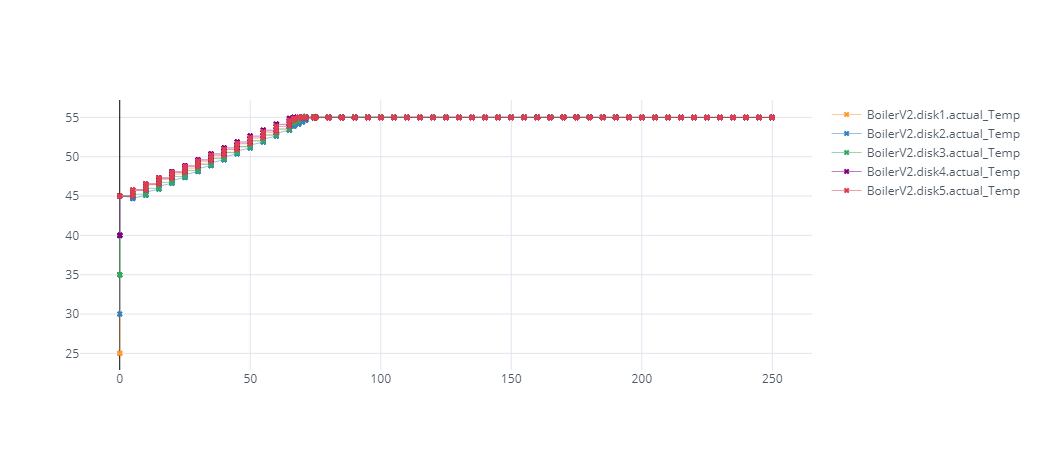

In [14]:
# This boiler is the same than the first one with MixingDIsk2 instead of the first version

@nodependencies
class BoilerV2(Entity, ElectricalDevice, WaterDevice):

    """ - - - - - - - PORTS - - - - - - - - - - """

    switch_boiler = Input(Resources.switch, "on")
    water_need = Input(Resources.water, 8)
        
    max_Capacity = Local(Resources.water,60)
    cons_Boiler = Local(Resources.electricity,4000)
    boiler_efficiency = Local(Resources.pourcent, 1)

    def __init__(self, consumption=4000, efficiency = 1, boiler_Capacity = 60):
        self.cons_Boiler.value = consumption
        self.boiler_efficiency.value = efficiency
        self.max_Capacity.value = boiler_Capacity
    
    
    """ - - - - - - - SUBENTITIES - - - - - - - - - - """

    disk1 = MixingDisk2()
    disk2 = MixingDisk2()
    disk3 = MixingDisk2()
    disk4 = MixingDisk2()
    disk5 = MixingDisk2()
    

    """ - - - - - - - STATES & TRANSITIONS - - - - - - - - - - """

    state = current = State()
    
    """ - - - - - - - INFLUENCES - - - - - - - - - - """
    influence_switch1 = Influence(source=switch_boiler, target=disk1.switch_boiler)
    influence_switch2 = Influence(source=switch_boiler, target=disk2.switch_boiler)
    influence_switch3 = Influence(source=switch_boiler, target=disk3.switch_boiler)
    influence_switch4 = Influence(source=switch_boiler, target=disk4.switch_boiler)
    influence_switch5 = Influence(source=switch_boiler, target=disk5.switch_boiler)
    
    influence_water_1 = Influence(source=water_need, target=disk1.water_drawn)
    influence_water_2 = Influence(source=water_need, target=disk2.water_drawn)
    influence_water_3 = Influence(source=water_need, target=disk3.water_drawn)
    influence_water_4 = Influence(source=water_need, target=disk4.water_drawn)
    influence_water_5 = Influence(source=water_need, target=disk5.water_drawn)
    
    #dep1 = Dependency(source="req_water_out", target=water_need)

    """ - - - - - - - UPDATES - - - - - - - - - - """
    
    influence_temp_up_1 = Influence(source = disk1.actual_Temp, target = disk1.temp_up)
    influence_temp_up_2 = Influence(source = disk1.actual_Temp, target = disk2.temp_up)
    influence_temp_up_3 = Influence(source = disk2.actual_Temp, target = disk3.temp_up)
    influence_temp_up_4 = Influence(source = disk3.actual_Temp, target = disk4.temp_up)
    influence_temp_up_5 = Influence(source = disk4.actual_Temp, target = disk5.temp_up)
    influence_temp_down_1 = Influence(source = disk2.actual_Temp, target = disk1.temp_down)
    influence_temp_down_2 = Influence(source = disk3.actual_Temp, target = disk2.temp_down)
    influence_temp_down_3 = Influence(source = disk4.actual_Temp, target = disk3.temp_down)
    influence_temp_down_4 = Influence(source = disk5.actual_Temp, target = disk4.temp_down)
    influence_temp_down_5 = Influence(source = disk5.actual_Temp, target = disk5.temp_down)

    """@update(state=state, target= disk1.temp_up)
    def set_Temp_up_d1(self, dt):

        return self.disk1.actual_Temp.value
    
    @update(state=state, target= disk2.temp_up)
    def set_Temp_up_d2(self, dt):

        return self.disk1.actual_Temp.value
    
    @update(state=state, target= disk3.temp_up)
    def set_Temp_up_d3(self, dt):

        return self.disk2.actual_Temp.value
    
    @update(state=state, target= disk4.temp_up)
    def set_Temp_up_d4(self, dt):

        return self.disk3.actual_Temp.value
    
    @update(state=state, target= disk5.temp_up)
    def set_Temp_up_d5(self, dt):

        return self.disk4.actual_Temp.value
    ""
    @update(state=state, target= disk1.temp_down)
    def set_Temp_up_d1(self, dt):

        return self.disk2.actual_Temp.value
    
    @update(state=state, target= disk2.temp_down)
    def set_Temp_up_d2(self, dt):

        return self.disk3.actual_Temp.value
    
    @update(state=state, target= disk3.temp_down)
    def set_Temp_up_d3(self, dt):

        return self.disk4.actual_Temp.value
    
    @update(state=state, target= disk4.temp_down)
    def set_Temp_up_d4(self, dt):

        return self.disk5.actual_Temp.value
    
    @update(state=state, target= disk5.temp_down)
    def set_Temp_up_d5(self, dt):

        return self.disk5.actual_Temp.value"""
    
    
#elk.plot(Boiler())

bt=BoilerV2()
bt.electricity_in.value=4000

bt.disk1.actual_Temp.value = 25
bt.disk2.actual_Temp.value = 30
bt.disk3.actual_Temp.value = 35
bt.disk4.actual_Temp.value = 40
bt.disk5.actual_Temp.value = 45

sim1=Simulator(bt)
sim1.stabilize
for i in range(50):
    sim1.advance(5)
sim1.plot(level = 2)    
sim1.traces.plot(traces=[bt.disk1.actual_Temp, bt.disk2.actual_Temp, bt.disk3.actual_Temp, bt.disk4.actual_Temp, bt.disk5.actual_Temp])

In [12]:
# Final boiler that works properly as we wanted to. You can also choose the number of disks you want. Be careful, can be long if you want to 
# add a lot of them

@nodependencies
class DynamicBoilerV1(Entity, ElectricalDevice, WaterDevice):

    """ - - - - - - - PORTS - - - - - - - - - - """

    switch_boiler = Input(Resources.switch, "on")
    water_need = Input(Resources.water, 8)
        
    nb_disks = 0
    max_Capacity = Local(Resources.water,60)
    cons_Boiler = Local(Resources.electricity,4000)
    boiler_efficiency = Local(Resources.pourcent, 1)

    def __init__(self, nb_disk=5, consumption=4000, efficiency = 1, boiler_Capacity = 60):
        self.cons_Boiler.value = consumption
        self.boiler_efficiency.value = efficiency
        self.max_Capacity.value = boiler_Capacity
        self.nb_disks = nb_disk
    
        disks = []
        for i in range(self.nb_disks):
            disk = api.add(self, f"disk_{i+1}", MixingDisk2())
            disks.append(disk)
            api.add(self, f"connect_disk_{i+1}_switch", Influence(source=self.switch_boiler, target=disk.switch_boiler))
            api.add(self, f"influence_water_{i+1}", Influence(source=self.water_need, target=disk.water_drawn))
            
        for i in range(self.nb_disks):
            api.add(self, f"temp_up_disk_{i+1}", Influence(source=disks[i].actual_Temp, target=disks[max(i-1,1)].temp_up))
            api.add(self, f"temp_down_disk_{i+1}", Influence(source=disks[i].actual_Temp, target=disks[min(i+1,self.nb_disks-1)].temp_down))
   

    state = current = State()

#elk.plot(DynamicBoilerV1())

bt=DynamicBoilerV1(nb_disk=10)
bt.electricity_in.value=4000
bt.water_in.value=4000
"""
bt.disk1.actual_Temp.value = 25
bt.disk2.actual_Temp.value = 30
bt.disk3.actual_Temp.value = 35
bt.disk4.actual_Temp.value = 40
bt.disk5.actual_Temp.value = 45
"""
sim1=Simulator(bt)
sim1.stabilize
for i in range(50):
    sim1.advance(5)
sim1.plot()
